# Train Simple Image Classifier

Task: Train a simple image classifier using cross-entropy loss

## Setup

In [1]:
from fastai.vision.all import *
from fastbook import *

# Input tensors get tagged as `TensorImageBW`, and they keep that tag even after going through the model.
# I'm not sure how you're supposed to drop that tag, but this works around a type dispatch error.
TensorImageBW.register_func(F.cross_entropy, TensorImageBW, TensorCategory)

import sys
if sys.platform == "darwin":
    # https://stackoverflow.com/a/64855500/69707
    import os
    os.environ['OMP_NUM_THREADS'] = '1'

Load up the MNIST dataset. It has 10 digits.

In [2]:
path = untar_data(URLs.MNIST)
path

Path('/scratch/cs344/data/mnist_png')

Create a subset of the images, so we train faster. We do this by taking 500 random images of each digit.

In [3]:
set_seed(0)
num_imgs_per_digit = 500
items = L([
    p
    for split in ['training', 'testing']
    for digit in range(10)
    for p in (path/split/str(digit)).ls().shuffle()[:num_imgs_per_digit]
])

Create the `dataloaders`. We need a slightly special `ImageBlock` because we want grayscale images.

In [4]:
block = DataBlock(
    blocks=(ImageBlock(PILImageBW), CategoryBlock),
    get_y = parent_label,
    splitter=GrandparentSplitter(train_name='training', valid_name="testing"),
)
dataloaders = block.dataloaders(items, bs=16)
print(f"{dataloaders.train.n} training images, {dataloaders.valid.n} validation images")

5000 training images, 5000 validation images


Let's inspect a batch of data.

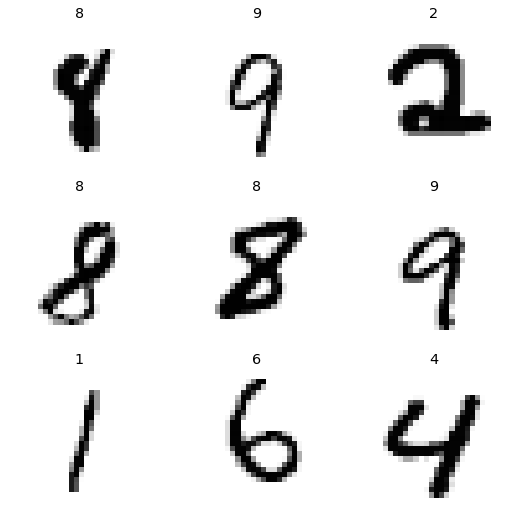

In [5]:
dataloaders.train.show_batch()

In [6]:
print(f"Available categories: {dataloaders.train.vocab}")

Available categories: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## Task



Let's make a neural network to predict which digit was written, using the raw pixel values. We'll keep it at a *single* layer today, so this is actually just a fancy way of doing *logistic regression*. But it'll give us a chance to work with minibatches and loss functions.

Step 1: Create a linear layer of the appropriate dimensionality.

- Like we did in Homework 4, we'll flatten the images before giving them to the linear layer. They are 28 pixels square.
- Unlike in Homework 4, we're trying to predict which of 10 digits. So think about the output dimensionality.
- We'll turn `bias` off because it's redundant in this setting.

In [7]:
linear_1 = nn.Linear(in_features=784, out_features=10, bias=False)
model = nn.Sequential(
    nn.Flatten(),
    linear_1,
)

model.to('cuda')

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=False)
)

To find the `in_feature` I squared 28 pixels.
To find the `out_feature` I multipled 10 (number of digits) by 1 (the number of layers).

We test out our model on one batch of data.

In [8]:
images, labels = dataloaders.train.one_batch()
images = TensorBase(images) # work around a fastai quirk
images.shape

torch.Size([16, 1, 28, 28])

In [9]:
logits = model(images)
assert logits.shape == (16, 10)
logits.shape

torch.Size([16, 10])

Think about why `logits.shape` contains those two numbers. 

In [10]:
labels

TensorCategory([0, 9, 8, 6, 0, 6, 8, 3, 1, 6, 5, 0, 0, 7, 7, 9], device='cuda:0')

Now let's compute the cross-entropy loss. We'll use [`F.cross_entropy`](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html#torch.nn.functional.cross_entropy) from PyTorch, which has the following basic signature (simplified somewhat from the official docs):

```python
F.cross_entropy(
  logits: Tensor[Batch, Categories], # the unnormalized scores of each class, for each item in the batch
  target: TensorCategory[Batch],     # the correct label index (an int) for each item in the class
  reduction: str = 'mean'            # whether to return a single number for the average loss across the batch ('mean') or not ('none')
  label_smoothing: float = 0.0       # how much label smoothing to apply (none by default)
)
```

Let's try it on our logits and labels for this batch. (I'm unsure why it's still a `TensorCategory`, it should just be a normal `Tensor`.)

In [11]:
loss = F.cross_entropy(logits, labels, reduction='none')
loss

TensorCategory([2.5734, 2.1700, 2.1369, 2.3314, 2.3710, 2.3239, 2.2153, 2.4062, 2.1970, 2.4140, 2.4134, 2.5653, 2.3489, 2.5987, 2.2779, 2.2251], device='cuda:0', grad_fn=<AliasBackward0>)

In [12]:
loss.mean()

TensorCategory(2.3480, device='cuda:0', grad_fn=<AliasBackward0>)

We can use `argmax` to ask *which* category got the highest probability for each label. This will be useful for computing a *metric* like accuracy.

In [13]:
predictions = logits.argmax(dim=1)
print(predictions.shape)
predictions

torch.Size([16])


TensorBase([7, 8, 2, 2, 5, 5, 1, 0, 0, 7, 1, 7, 1, 8, 0, 2], device='cuda:0')

Now, fill in the blanks in the code below to train the model.

Epoch  0: loss=1.06, train accuracy 3851/4992
Epoch  1: loss=0.83, train accuracy 4282/4992
Epoch  2: loss=0.72, train accuracy 4359/4992
Epoch  3: loss=0.65, train accuracy 4430/4992
Epoch  4: loss=0.60, train accuracy 4450/4992
Epoch  5: loss=0.57, train accuracy 4466/4992
Epoch  6: loss=0.54, train accuracy 4489/4992
Epoch  7: loss=0.52, train accuracy 4505/4992
Epoch  8: loss=0.50, train accuracy 4509/4992
Epoch  9: loss=0.48, train accuracy 4530/4992


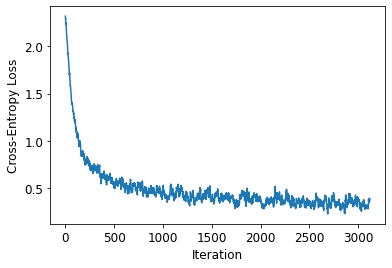

In [26]:
num_epochs = 10
learning_rate = 0.025
losses = []

# Re-initialize the parameters of the model, so training restarts when this block starts.
linear_1.reset_parameters()
for epoch in range(num_epochs):
    # Keep track of some things for each epoch.
    total_images = 0
    total_correct = 0
    for images, labels in dataloaders.train:
        images = TensorBase(images) # work around a quirk in fastai, ignore this
        logits = model(images)
        loss = F.cross_entropy(logits, labels)

        # take an SGD step.
        loss.backward()
        for parameter in model.parameters():
            parameter.data -= learning_rate * parameter.grad
        model.zero_grad()

        # Track metrics
        predictions = logits.argmax(axis=1)
        num_accurate = (predictions == labels).sum()
        total_images += len(labels)
        total_correct += num_accurate

        # Track losses.
        losses.append(loss.item())

    # Epoch done, print some stats.
    avg_loss_this_epoch = np.mean(losses[-total_images:])
    print(f"Epoch {epoch:2d}: loss={avg_loss_this_epoch:.2f}, train accuracy {total_correct:3d}/{total_images}")

# Plot the un-smoothed loss
#plt.plot(losses)
# Plot a smoothed version of the loss (easier to see the trend)
pd.Series(losses).ewm(alpha = .1).mean().plot()
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss");

How can we tell if the learning rate is too high based on the graph? like, will this part be higher?

Let's inspect the weights of our trained network. Since we have a single layer, it's relatively easy to do this. First, look at the weights of the `linear_1` layer:

In [17]:
linear_1.weight.shape

torch.Size([10, 784])

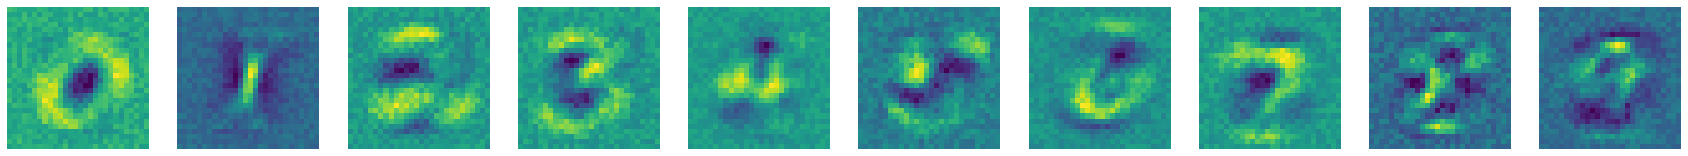

In [18]:
weight_images = linear_1.weight.data.view((10, 28, 28))
show_images(weight_images)

## Analysis

Q1: Why is `logits.shape` 16 by 10?

It's because the batch size is 16 and the output is 10 (because we have 10 digits)

Q2:  Before we trained the model (i.e., it just had random weights), the cross entropy was all about the same number. What was that number, and why? Hint:

In [19]:
np.log(10)

2.302585092994046

When computing the log-likelihood in Python, Python uses `e` as the base. 

Q3: Adjust the learning rate parameter. Give an example of a learning rate that is too high, one that is too low, and one that is good. For each, explain your answer by describing what the loss curve looks like.

- Too high
    - Learning rate: 10
    - The curve dramatically (exponentially) declines; then, it plateaus. The curve almost looks like an L 
- Too low
    - Learning rate: 0.0001
    - The curve descends almost linearly (oscillating up and down of course, but overall trend seems linear descent)
- Good 
    - Learning rate: 0.025
    - The curve isn't too steep and isn't too linear. It actually looks like it has a nice curve. 

Q4: Why the weight images look the way they do? (Why might they look similar to the digits in question? Why might they look not exactly like the digits in question?)

They look the way they do because that is the model's interpretation of what those digits are. The bright areas are the pixels in which the model uses to predict the digit in question. It might not look exactly like the digit in question because of low confidence.